## Dominik Adamczyk
### Mownit Lab5 rozwiązania

##### Mnożenie macierzy

In [1]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end


# poprawiona funkcja korzytająca z powyższego oraz z faktu, że
# można zmieniać kolejność operacji dodawania (a co za tym idzie kolejnosc petli).
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end


better_multiplication (generic function with 1 method)

1. **(1pkt)** Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [2]:
using DataFrames

function compare_times(repeats, range)
    df = DataFrame(type = String[], size = Int64[], time = Float64[])
    for _ in 1:repeats
        for i in range
            A = rand(i, i)
            B = rand(i, i)
            push!(df, ["naive_multiplication", i, @elapsed naive_multiplication(A, B)])
            push!(df, ["better_multiplication", i, @elapsed better_multiplication(A, B)])
            push!(df, ["BLAS_multiplication", i, @elapsed A * B])
        end
    end
    df
end
            

compare_times (generic function with 1 method)

In [3]:
repeats = 10
sizes = 150:150:1500

# df = compare_times(repeats, sizes)
# CSV.write("times_julia.csv", df)


150:150:1500


(process:4800): GLib-GIO-WARNING **: 04:05:48.804: Failed to open application manifest `C:\Windows\SystemApps\Microsoft.Windows.Search_cw5n1h2txyewy\AppxManifest.xml' for package #0 (`Microsoft.Windows.Search_1.16.0.22000_neutral_neutral_cw5n1h2txyewy'): error code 0x2


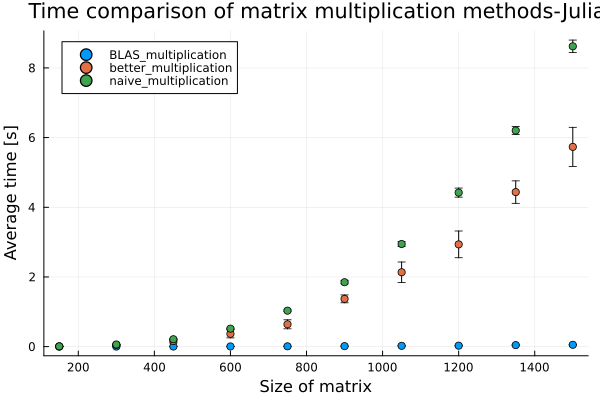

In [4]:
using Statistics
using Plots
using CSV


df=CSV.read("times_julia.csv", delim=",",DataFrame)

stats = combine(groupby(df, [:type, :size]),
"time" => mean, "time" => std)

scatter(stats.size, stats.time_mean,
group=stats.type, yerr=stats.time_std,
xlabel="Size of matrix", ylabel="Average time [s]",
title = "Time comparison of matrix multiplication methods-Julia")

2. **(2 pkt)** Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy (wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). 
    
    Do analizy danych można użyć wybranego narzędzia (Julia, R)
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 


#### Kod w języku C:
```c
#include <stdio.h>
#include <gsl/gsl_blas.h>
#include <stdlib.h>
#include <time.h>


double * rand_arr(int size){
    double * arr = malloc(size * size * sizeof(double));
    for (int i = 0; i < size * size; i++){
        arr[i] = (double) rand();
    }
    return (arr);
}

double * zero_arr(int size){
    double * arr = malloc(size * size * sizeof(double));
    for (int i = 0; i < size * size; i++){
        arr[i] = 0;
    }
    return (arr);
}

double** arr_to_matrix(double * arr, int size){
    double ** mat = (double **) malloc (size * sizeof(double*));
    for (int i = 0; i < size; i++){
        mat[i] = (double *) malloc(size * sizeof(double));
        for (int j = 0; j <  size; j++){
            mat[i][j] = arr[i * size + j];
        }
    }
    return mat;
}

double** naive_multiplication(double** A, double** B, int m, int n, int p) {
    double** C = (double**) malloc(m * sizeof(double*)); 
    for (int i = 0; i < m; i++) {
        C[i] = (double*) calloc(p, sizeof(double));
    }

    for (int i = 0; i < m; i++) {
        for (int j = 0; j < p; j++) {
            for (int k = 0; k < n; k++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
    return C;
}

double** better_multiplication(double** A, double** B, int m, int n, int p) {
    double** C = (double**) malloc(m * sizeof(double*)); 
    for (int i = 0; i < m; i++) {
        C[i] = (double*) calloc(p, sizeof(double));
    }

    for (int i = 0; i < m; i++) {
        for (int k = 0; k < n; k++) {
            for (int j = 0; j < p; j++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
    return C;
}

int BLAS_multiplication(gsl_matrix_view A, gsl_matrix_view B, gsl_matrix_view C){
    return gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, &A.matrix, &B.matrix, 0.0, &C.matrix);
}

void single_test(int repeats, int size){
    clock_t start_time, end_time;
    double elapsed_time;
    for (int i = 0; i < repeats; i++){
        double * A_lin = rand_arr(size);
        double * B_lin = rand_arr(size);
        double * C_lin = zero_arr(size);
        double ** A = arr_to_matrix(A_lin, size);
        double ** B = arr_to_matrix(B_lin, size);
        gsl_matrix_view A_blas = gsl_matrix_view_array(A_lin, size, size);
        gsl_matrix_view B_blas = gsl_matrix_view_array(B_lin, size, size);
        gsl_matrix_view C_blas = gsl_matrix_view_array(C_lin, size, size);

        start_time = clock();
        double ** D = naive_multiplication(A, B, size, size, size);
        end_time = clock();
        elapsed_time = ((double) (end_time - start_time)) / CLOCKS_PER_SEC;
        printf("naive_multiplication,%d,%f\n", size, elapsed_time);
        
        
        start_time = clock();
        double ** E = better_multiplication(A, B, size, size, size);
        end_time = clock();
        elapsed_time = ((double) (end_time - start_time)) / CLOCKS_PER_SEC;
        printf("better_multiplication,%d,%f\n", size, elapsed_time);


        start_time = clock();
        BLAS_multiplication(A_blas, B_blas, C_blas);
        end_time = clock();
        elapsed_time = ((double) (end_time - start_time)) / CLOCKS_PER_SEC;
        printf("BLAS_multiplication,%d,%f\n", size, elapsed_time);

        free(A_lin);
        free(B_lin);
        free(C_lin);
        for(int j = 0; j < size; j++){
            free(A[j]);
            free(B[j]);
            free(E[j]);
            free(D[j]);
        }
        free(E);
        free(D);
        free(A);
        free(B);
    }
}

int main (void){
    srand(time(NULL));
    
    printf("type,size,time\n");

    for (int i = 150; i <= 1500; i += 150){
        single_test(10, i);
    }
    
    return 0;
}
```

#### Makefile:

```makefile
all:
	gcc -Wall -I/usr/local/include -c multiplication.c
	gcc multiplication.o -lgsl -lgslcblas -lm -o multiplication

prepare:
	LD_LIBRARY_PATH=/usr/local/lib
	export LD_LIBRARY_PATH

run:
	make all
	rm -f multiplication.o
	./multiplication > times_c.csv

```

In [5]:
data = CSV.read("times_c.csv", delim=",",DataFrame)

Row,type,size,time
,String31,Int64,Float64
1,naive_multiplication,150,0.010793
2,better_multiplication,150,0.010519
3,BLAS_multiplication,150,0.001649
4,naive_multiplication,150,0.011214
5,better_multiplication,150,0.011067
6,BLAS_multiplication,150,0.001538
7,naive_multiplication,150,0.010518
8,better_multiplication,150,0.010509
9,BLAS_multiplication,150,0.001593


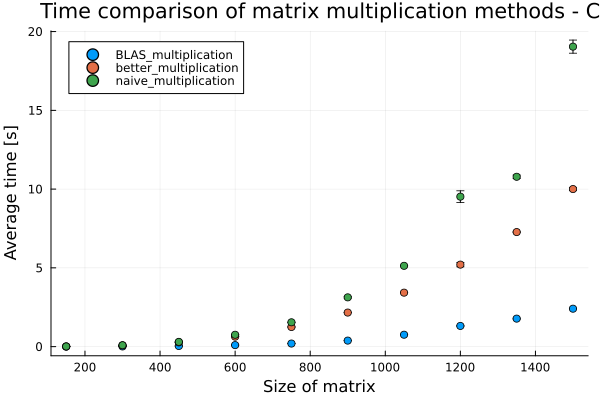

In [6]:
stats_c = combine(groupby(data, [:type, :size]),
"time" => mean, "time" => std)

scatter(stats_c.size, stats_c.time_mean,
group=stats_c.type, yerr=stats_c.time_std,
xlabel="Size of matrix", ylabel="Average time [s]",
title = "Time comparison of matrix multiplication methods - C")

3. **(1 pkt)** Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. Do analizy danych można użyć wybranego narzędzia (Julia, R)

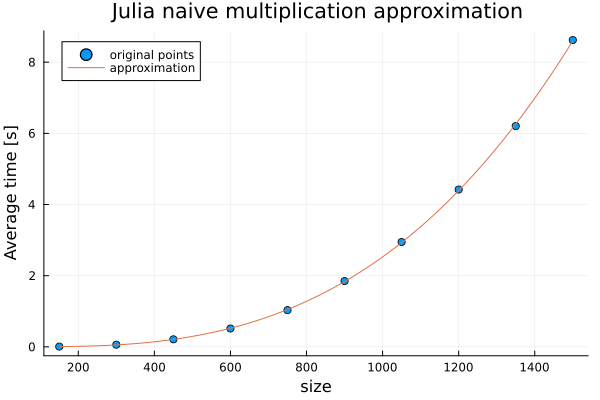

In [7]:
x_values = stats[stats[:,1] .== "naive_multiplication", 2]
naive_julia = stats[stats[:,1] .== "naive_multiplication", 3]
better_julia = stats[stats[:,1] .== "better_multiplication", 3]
blas_julia = stats[stats[:,1] .== "BLAS_multiplication", 3]

naive_c = stats_c[stats_c[:,1] .== "naive_multiplication", 3]
better_c = stats_c[stats_c[:,1] .== "better_multiplication", 3]
blas_c = stats_c[stats_c[:,1] .== "BLAS_multiplication", 3]


using Polynomials
naive_julia_pol = fit(x_values, naive_julia, 3)
scatter(x_values, naive_julia, label="original points", xlabel="size", ylabel="Average time [s]")
plot!(naive_julia_pol, extrema(x_values)..., title="Julia naive multiplication approximation", label="approximation")

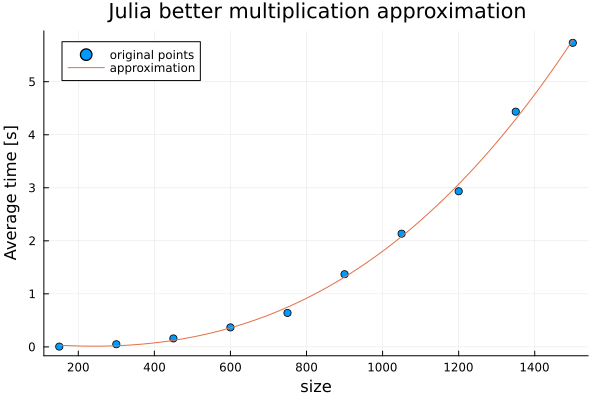

In [8]:
better_julia_pol = fit(x_values, better_julia, 3)
scatter(x_values, better_julia, label="original points", xlabel="size", ylabel="Average time [s]")
plot!(better_julia_pol, extrema(x_values)..., title="Julia better multiplication approximation", label="approximation")

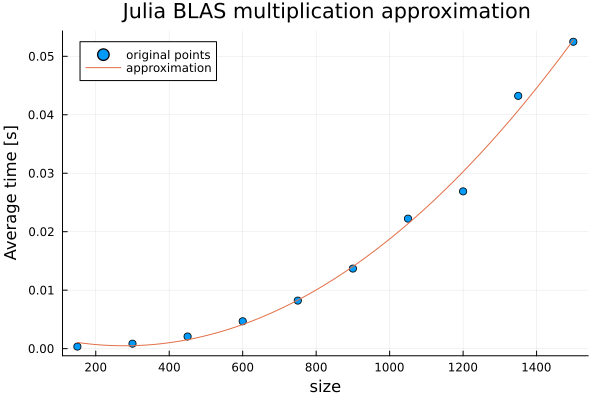

In [9]:
blas_julia_pol = fit(x_values, blas_julia, 2)
scatter(x_values, blas_julia, label="original points", xlabel="size", ylabel="Average time [s]")
plot!(blas_julia_pol, extrema(x_values)..., title="Julia BLAS multiplication approximation", label="approximation")

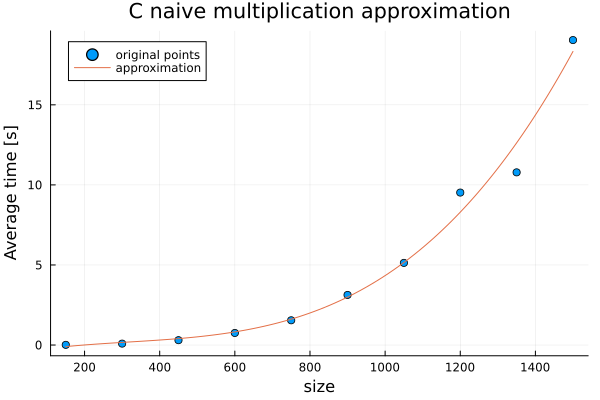

In [10]:
naive_c_pol = fit(x_values, naive_c, 3)
scatter(x_values, naive_c, label="original points", xlabel="size", ylabel="Average time [s]")
plot!(naive_c_pol, extrema(x_values)..., title="C naive multiplication approximation", label="approximation")

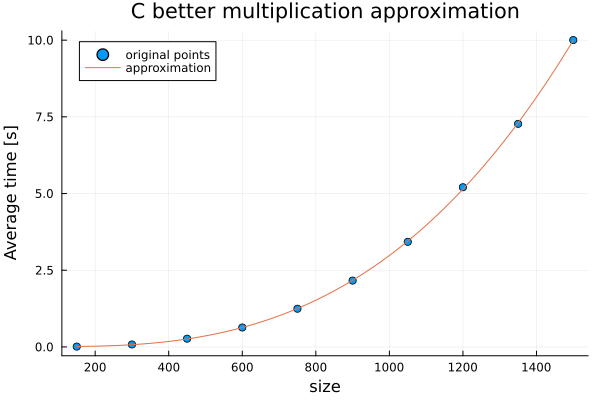

In [11]:
better_c_pol = fit(x_values, better_c, 3)
scatter(x_values, better_c, label="original points", xlabel="size", ylabel="Average time [s]")
plot!(better_c_pol, extrema(x_values)..., title="C better multiplication approximation", label="approximation")

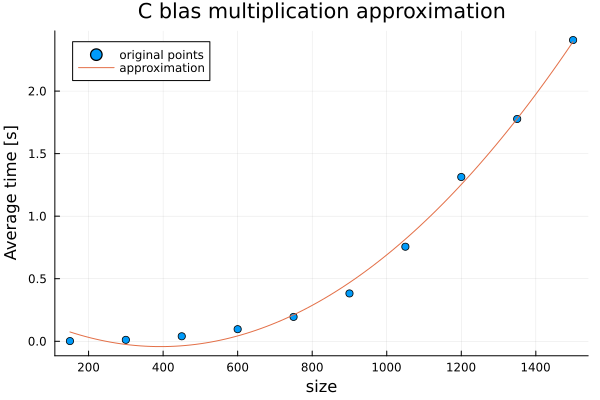

In [12]:
blas_c_pol = fit(x_values, blas_c, 2)
scatter(x_values, blas_c, label="original points", xlabel="size", ylabel="Average time [s]")
plot!(blas_c_pol, extrema(x_values)..., title="C blas multiplication approximation", label="approximation")

4. **(1 pkt)** Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. 

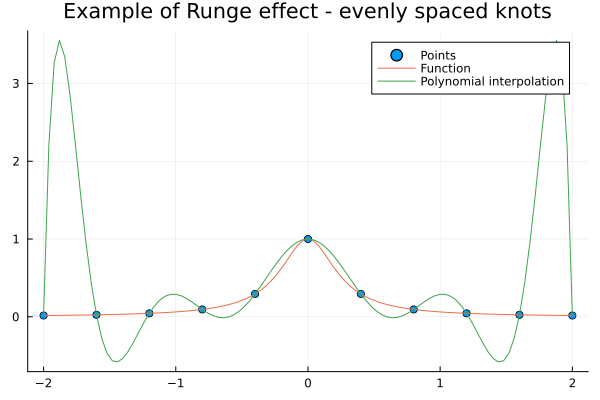

In [13]:
function f(x)
    1/(1+15x^2)
end

x_values = -2:0.4:2
y_values = f.(x_values)
interpol = fit(x_values, y_values, 10)


scatter(x_values, y_values, label="Points", title="Example of Runge effect - evenly spaced knots")
plot!(f, extrema(x_values)..., label="Function")
plot!(interpol, extrema(x_values)..., label="Polynomial interpolation")

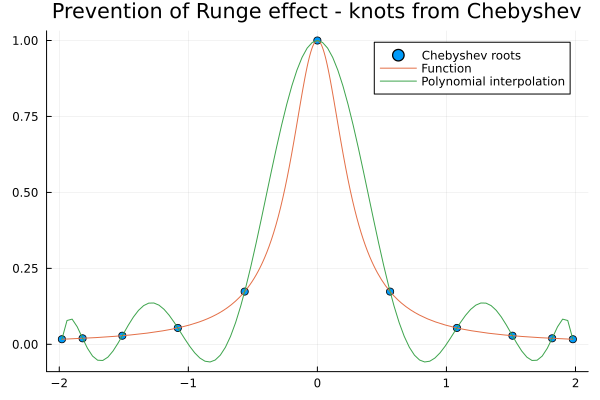

In [14]:
b = zeros(11)
append!(b, 1)
ch = ChebyshevT(b)
x_values = Polynomials.roots(ch) * 2

y_values = f.(x_values)
interpol = fit(x_values, y_values, 10)


scatter(x_values, y_values, label="Chebyshev roots", title="Prevention of Runge effect - knots from Chebyshev")
plot!(f, extrema(x_values)..., label="Function")
plot!(interpol, extrema(x_values)..., label="Polynomial interpolation")


5. **(1 pkt)** Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ 

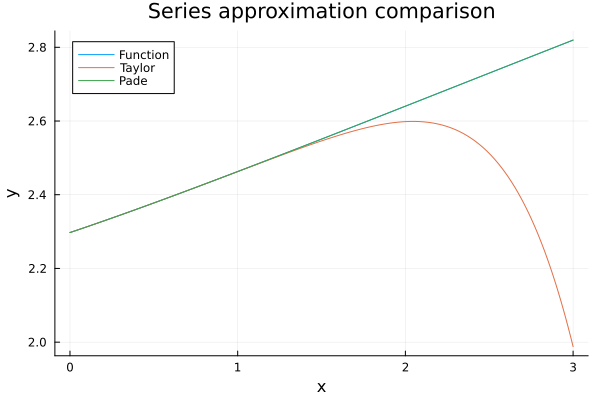

In [15]:
using TaylorSeries

function f(x)
    (7+(1+x)^(4/3))^(2/5)
end

T = Taylor1(Float64, 7)
TT = f(T)
TA = Polynomial(TT.coeffs)

PA = Polynomials.PolyCompat.PadeApproximation.Pade(TA, 3, 3)

x = 0:0.01:3

y1 = f.(x)
y2 = TA.(x)
y3 = PA.(x)

plot(x, [y1, y2, y3], xlabel="x", ylabel="y", title="Series approximation comparison", label=["Function" "Taylor" "Pade"])

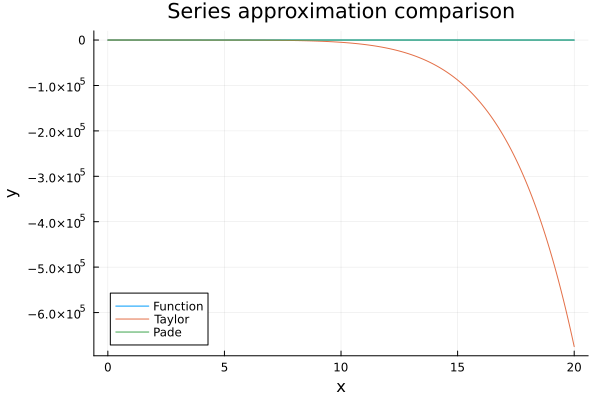

In [16]:
x = 0:0.01:20

y1 = f.(x)
y2 = TA.(x)
y3 = PA.(x)

plot(x, [y1, y2, y3], xlabel="x", ylabel="y", title="Series approximation comparison", label=["Function" "Taylor" "Pade"])

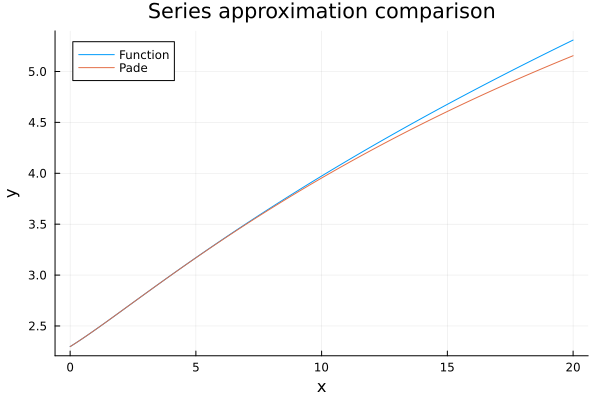

In [17]:
x = 0:0.01:20

y1 = f.(x)
y3 = PA.(x)

plot(x, [y1, y3], xlabel="x", ylabel="y", title="Series approximation comparison", label=["Function" "Pade"])